In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install category_encoders
!pip install xgboost
!pip install eli5
!pip install shap
!pip install pdpbox

     |████████████████████████████████| 86 kB 3.7 MB/s 
     |████████████████████████████████| 106 kB 8.3 MB/s 
     |████████████████████████████████| 564 kB 6.8 MB/s 
     |████████████████████████████████| 34.0 MB 228 kB/s 
     |████████████████████████████████| 13.1 MB 38.7 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=53c9aa0b56f03a110286d834dda31ad157eccf4045119ff73b04d15c862b2835
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which

 id : 선수 고유의 아이디
 
 name : 이름
 
 age : 나이
 
 continent : 선수들의 국적이 포함되어 있는 대륙입니다
 
 contract_until : 선수의 계약기간이 언제까지인지 나타내어 줍니다
 
 position : 선수가 선호하는 포지션입니다. ex) 공격수, 수비수 등
 
 prefer_foot : 선수가 선호하는 발입니다. ex) 오른발
 
 reputation : 선수가 유명한 정도입니다. ex) 높은 수치일 수록 유명한 선수
 
 stat_overall : 선수의 현재 능력치 입니다.
 
 stat_potential : 선수가 경험 및 노력을 통해 발전할 수 있는 정도입니다.
 
 stat_skill_moves : 선수의 개인기 능력치 입니다.
 
 value : FIFA가 선정한 선수의 이적 시장 가격 (단위 : 유로) 입니다

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

# 해외 축구 선수 데이터셋셋
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/codestates/soccer/FIFA_train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/codestates/soccer/FIFA_test.csv')
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/codestates/soccer/submission.csv')

In [4]:
train.shape, test.shape

((8932, 12), (3828, 11))

In [5]:
train.head()

id          name  age      continent contract_until position prefer_foot  \
0   0      L. Messi   31  south america           2021       ST        left   
1   3        De Gea   27         europe           2020       GK       right   
2   7     L. Suárez   31  south america           2021       ST       right   
3   8  Sergio Ramos   32         europe           2020       DF       right   
4   9      J. Oblak   25         europe           2021       GK       right   

   reputation  stat_overall  stat_potential  stat_skill_moves        value  
0         5.0            94              94               4.0  110500000.0  
1         4.0            91              93               1.0   72000000.0  
2         5.0            91              91               3.0   80000000.0  
3         4.0            91              91               3.0   51000000.0  
4         3.0            90              93               1.0   68000000.0

In [6]:
test.head()

id               name  age      continent contract_until position  \
0   1  Cristiano Ronaldo   33         europe           2022       ST   
1   2          Neymar Jr   26  south america           2022       ST   
2   4       K. De Bruyne   27         europe           2023       MF   
3   5          E. Hazard   27         europe           2020       ST   
4   6          L. Modrić   32         europe           2020       MF   

  prefer_foot  reputation  stat_overall  stat_potential  stat_skill_moves  
0       right         5.0            94              94               5.0  
1       right         5.0            92              93               5.0  
2       right         4.0            91              92               4.0  
3       right         4.0            91              91               4.0  
4       right         4.0            91              91               4.0

In [7]:
# 결측치 없음, 데이터 타입 확인
# 타겟 value 실수형 확인
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [8]:
# 중복값 없음
train.duplicated().sum()

0

In [9]:
# 불필요한 컬럼 제거
train = train.drop(columns = ['id', 'name'], axis = 1)
test = test.drop(columns = ['id', 'name'], axis = 1 )

In [10]:
# 계약기간 통일
train.contract_until.unique()

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

In [11]:
train['contract_until'] = train['contract_until'].replace('Dec 31, 2018', '2018')
train['contract_until'] = train['contract_until'].replace(['Jun 30, 2019','May 31, 2019','Jan 31, 2019','Jan 1, 2019', 'Jan 12, 2019'],'2019')
train['contract_until'] = train['contract_until'].replace(['Jun 30, 2020','May 31, 2020'])
train['contract_until'].astype(int)
train.contract_until.value_counts()

2019    2901
2021    2310
2020    2044
2022     762
2023     508
2018     391
2024      12
2025       3
2026       1
Name: contract_until, dtype: int64

In [12]:
test['contract_until'] = test['contract_until'].replace('Dec 31, 2018', '2018')
test['contract_until'] = test['contract_until'].replace(['Jun 30, 2019','May 31, 2019','Jan 31, 2019','Jan 1, 2019', 'Jan 12, 2019','Dec 31, 2019','Jun 1, 2019'],'2019')
test['contract_until'] = test['contract_until'].replace(['Jun 30, 2020','May 31, 2020'])
test['contract_until'].astype(int)
test.contract_until.value_counts()

2019    1172
2021     986
2020     883
2022     339
2023     252
2018     189
2025       4
2024       2
2026       1
Name: contract_until, dtype: int64

In [13]:
train.describe()

age   reputation  stat_overall  stat_potential  \
count  8932.000000  8932.000000   8932.000000     8932.000000   
mean     25.209136     1.130878     67.091133       71.997201   
std       4.635515     0.423792      6.854910        5.988147   
min      16.000000     1.000000     47.000000       48.000000   
25%      21.000000     1.000000     63.000000       68.000000   
50%      25.000000     1.000000     67.000000       72.000000   
75%      28.000000     1.000000     72.000000       76.000000   
max      40.000000     5.000000     94.000000       94.000000   

       stat_skill_moves         value  
count       8932.000000  8.932000e+03  
mean           2.401702  2.778673e+06  
std            0.776048  5.840982e+06  
min            1.000000  1.000000e+04  
25%            2.000000  3.750000e+05  
50%            2.000000  8.250000e+05  
75%            3.000000  2.600000e+06  
max            5.000000  1.105000e+08

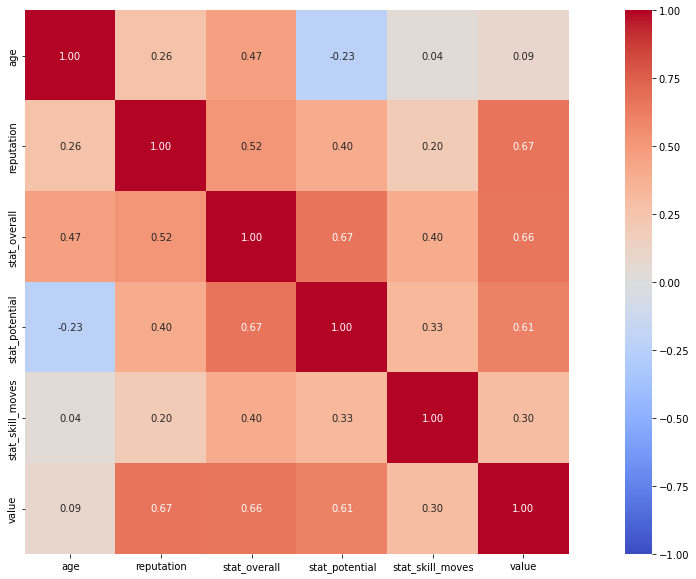

In [14]:
# 타겟값과 상관관계 분석
# value와 상관관계가 높은것은 reputation, stat_overall, stat_potential이다.
value_c = train.corr()

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(value_c,
               annot = True,      #상관계수 표시
               cbar = True,       #막대컬로 표시
               cmap='coolwarm',  #맵 색깔
               square = 'True',   #정사각형
               fmt = '.2f',       #소수점 자리
               vmin = -1, vmax = 1
              );

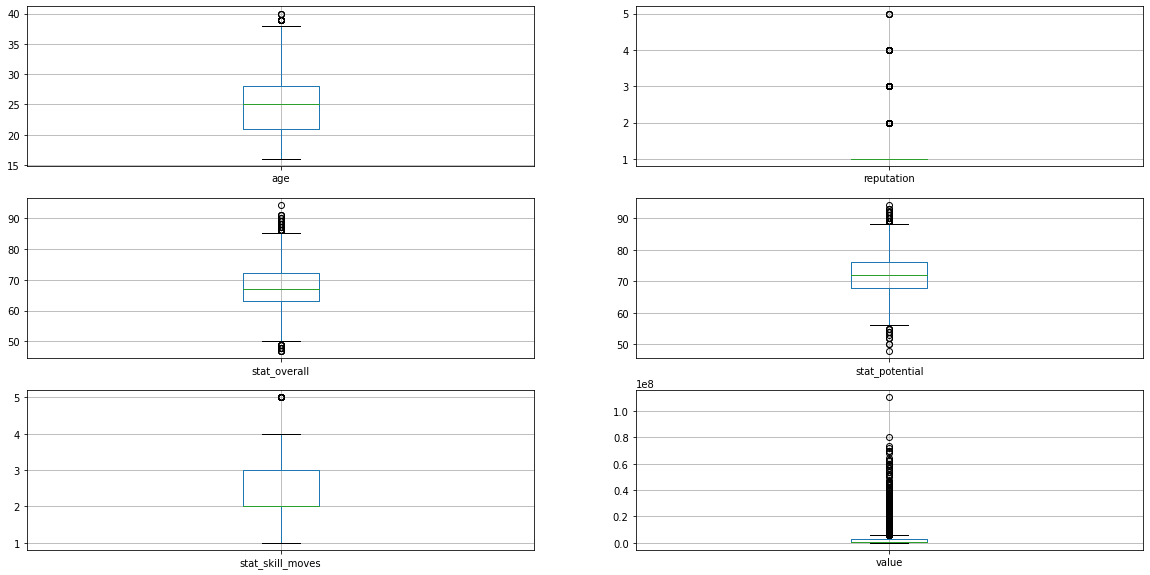

In [15]:
# 이상치 확인
plt.figure(figsize=(20, 10))
plt.subplot(3,2,1)
train.boxplot(column=['age'])

plt.subplot(3,2,2)
train.boxplot(column=['reputation'])

plt.subplot(3,2,3)
train.boxplot(column=['stat_overall'])

plt.subplot(3,2,4)
train.boxplot(column=['stat_potential'])

plt.subplot(3,2,5)
train.boxplot(column=['stat_skill_moves'])

plt.subplot(3,2,6)
train.boxplot(column=['value'])

plt.show();

In [16]:
"""
# 타겟의 이상치값 제거
q1 = train['value'].quantile(0.25)
q3 = train['value'].quantile(0.75)
iqr = q3 - q1

condition= train['value']>=q3+1.5*iqr
train[condition]

# a를 실행하면 covid[condition]의 모든 인덱스 번호가 리턴된다.
a = train[condition].index
train.drop(a,inplace=True)
"""

"\n# 타겟의 이상치값 제거\nq1 = train['value'].quantile(0.25)\nq3 = train['value'].quantile(0.75)\niqr = q3 - q1\n\ncondition= train['value']>=q3+1.5*iqr\ntrain[condition]\n\n# a를 실행하면 covid[condition]의 모든 인덱스 번호가 리턴된다.\na = train[condition].index\ntrain.drop(a,inplace=True)\n"

In [17]:
"""
# 타겟 이상치 확인 - 약간의 변화가 있지만 미미함
plt.figure(figsize=(8, 5))
train.boxplot(column=['value'])

plt.show();
"""

"\n# 타겟 이상치 확인 - 약간의 변화가 있지만 미미함\nplt.figure(figsize=(8, 5))\ntrain.boxplot(column=['value'])\n\nplt.show();\n"

baseline : 2778673.3094491716


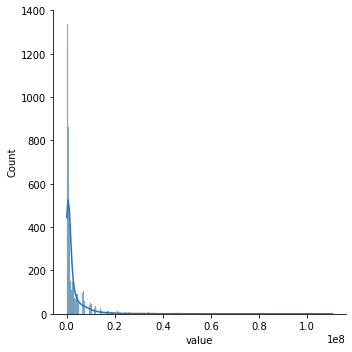

In [18]:
# 타겟 분포가 right-skewed인걸 확인
print('baseline :' ,train['value'].mean())
sns.displot(train['value'],kde=True);

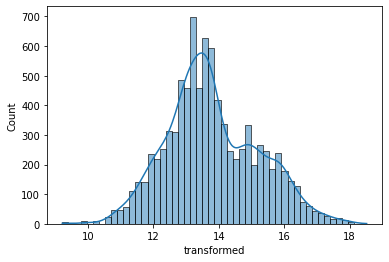

In [19]:
# 로그변환
plots=pd.DataFrame()
plots['transformed']=np.log1p(train['value'])

# 데이터 분포가 고르게 되었다.
sns.histplot(plots['transformed'],kde=True)

In [20]:
# 나라별 스탯 평균
print(train.groupby('continent')['stat_overall'].mean())
# 포지션별 스탯 평균
print(train.groupby('position')['stat_overall'].mean())
# 포지션별 나이 평균
print(train.groupby('position')['age'].mean())

continent
africa           68.041609
asia             63.381194
europe           67.083051
oceania          63.011429
south america    68.643487
Name: stat_overall, dtype: float64
position
DF    67.304192
GK    65.188492
MF    67.373104
ST    67.300293
Name: stat_overall, dtype: float64
position
DF    25.618058
GK    25.791667
MF    24.938156
ST    24.740176
Name: age, dtype: float64


In [21]:
f, ax = plt.subplots(3,3, figsize=(26,10))
ax = ax.flatten()
list = ['age','reputation','stat_overall','stat_potential','stat_skill_moves','continent','contract_until','position','prefer_foot']

for i in range(len(list)):
  sns.histplot(data = train, x = list[i],ax = ax[i])
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

target = 'value'
features = ['age','reputation','stat_overall','stat_potential','stat_skill_moves','continent','contract_until','position','prefer_foot']

train, val = train_test_split(train, train_size=0.8, test_size=0.2, random_state = 42) 
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [23]:
print('X_train shape:',X_train.shape)
print('X_val shape:',X_val.shape)

X_train shape: (7145, 9)
X_val shape: (1787, 9)


In [56]:
# 기준모델
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 모두 평균으로 예측
y_pred = [y_train.mean()] * len(y_val)

# 결과 확인
print('RMSE: ', np.sqrt(mean_squared_error(y_val, y_pred)))

RMSE:  6728548.821856157


In [28]:
from category_encoders import OneHotEncoder

encoder = OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [29]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_val_scaled = scaler.transform(X_val_encoded)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

model = LinearRegression()
model.fit(X_train_scaled, y_train)

#학습한 모델을 통해 예측해 봅니다
y_pred1 = model.predict(X_train_scaled)
mae1 = mean_absolute_error(y_train, y_pred1)
rmse1 = np.sqrt(mean_squared_error(y_train, y_pred1))
r2 = r2_score(y_train, y_pred1)

print(f'Train MAE: {mae1:.6f}')
print(f'Train R2 : {r2:.6f}')
print(f'Train RMSE : {rmse1:.6f}\n')

y_pred2 = model.predict(X_val_scaled)
mae2 = mean_absolute_error(y_val, y_pred2)
rmse2 = np.sqrt(mean_squared_error(y_val, y_pred2))
r2 = r2_score(y_val, y_pred2)

print(f'Val MAE: {mae2:.6f}')
print(f'Val R2 : {r2:.6f}')
print(f'Val RMSE : {rmse2:.6f}')

Train MAE: 1805143.462918
Train R2 : 0.666719
Train RMSE : 3231106.742144

Val MAE: 1970101.031395
Val R2 : 0.635861
Val RMSE : 4057544.080171


In [31]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

alphas = [0, 0.001, 0.01, 0.1, 1, 10]

# RidgeCV는 alpha로 넣고자 하는 값들을 리스트로 전달하면 내부적으로 최적의 alpha값을 찾아냄
ridgecv = RidgeCV(alphas=alphas, normalize=True, cv=5)
# cv : cross-validation -> 데이터를 k등분한 후 각각에 대하여 검증 진행
# 검증 결과 가장 점수가 높은 모델을 채택
ridgecv.fit(X_train_scaled, y_train)

y_pred3 = ridgecv.predict(X_train_scaled)
mae3 = mean_absolute_error(y_train, y_pred3)
rmse3 = np.sqrt(mean_squared_error(y_train, y_pred3))
r2 = r2_score(y_train, y_pred3)
print(f'Ridge Train MAE: {mae3:,.6f}')
print(f'Ridge Train R2 Score: {r2:,.6f}')
print(f'Ridge Train RMSE : {rmse3:.6f}')
print(f'alpha: {ridgecv.alpha_}') # 최종 결정된 alpha값
print(f'cv best score: {ridgecv.best_score_}\n') # 최종 alpha에서의 점수

y_pred4 = ridgecv.predict(X_val_scaled)
mae4 = mean_absolute_error(y_val, y_pred4)
rmse4 = np.sqrt(mean_squared_error(y_val, y_pred4))
r2 = r2_score(y_val, y_pred4)
print(f'Ridge Val MAE: {mae4:,.6f}')
print(f'Ridge Val R2 Score: {r2:,.6f}')
print(f'Ridge Val RMSE : {rmse4:.6f}')
print(f'alpha: {ridgecv.alpha_}')
print(f'cv best score: {ridgecv.best_score_}')

Ridge Train MAE: 1,802,635.604712
Ridge Train R2 Score: 0.666713
Ridge Train RMSE : 3231135.446730
alpha: 0.001
cv best score: 0.6563856592653752

Ridge Val MAE: 1,967,375.420477
Ridge Val R2 Score: 0.635762
Ridge Val RMSE : 4058091.956444
alpha: 0.001
cv best score: 0.6563856592653752


In [60]:
from category_encoders import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

pipe = make_pipeline(
       OneHotEncoder(), 
       RandomForestRegressor(random_state = 2),                         
)

dists = {     
    'randomforestregressor__n_estimators': randint(50, 1000), # randint 함수는 정수와 정수 사이의 값을 랜덤으로 생성
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter = 50, 
    cv = 3, 
    scoring= 'r2',  
    verbose = 1,
    n_jobs = -1
)

clf.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [61]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('r2 score: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.8808867215692857, 'randomforestregressor__n_estimators': 146}
r2 score:  0.97669496117564


In [62]:
clf.fit(X_val_scaled, y_val);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [63]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('r2 score: ', clf.best_score_)

최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 0.7289858270698941, 'randomforestregressor__n_estimators': 81}
r2 score:  0.9091189487060659


In [34]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_encoded.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train_encoded.columns)

In [83]:
from xgboost import XGBRegressor
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

xgb = XGBRegressor(learning_rate=0.2,
                    eval_set=[(X_train_scaled, y_train), (X_val_scaled, y_val)],
                    random_state=2,
                    max_depth=10,
                    n_estimators=1000,
                    early_stopping_rounds=50
)

xgb.fit(X_train_scaled, y_train, verbose=False)


y_pred5 = xgb.predict(X_train_scaled)
mae5 = mean_absolute_error(y_train, y_pred5)
rmse5 = np.sqrt(mean_squared_error(y_train, y_pred5))
r2 = r2_score(y_train, y_pred5)

print(f'Train MAE: {mae5:.6f}')
print(f'Train R2 : {r2:.6f}')
print(f'Train RMSE : {rmse5:.6f}\n')

y_pred6 = xgb.predict(X_val_scaled)
mae6 = mean_absolute_error(y_val, y_pred6)
rmse6 = np.sqrt(mean_squared_error(y_val, y_pred6))
r2 = r2_score(y_val, y_pred6)

print(f'Val MAE: {mae6:.6f}')
print(f'Val R2 : {r2:.6f}')
print(f'Val RMSE : {rmse6:.6f}')

[04:39:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train MAE: 1619.579042
Train R2 : 0.999987
Train RMSE : 20309.132253

Val MAE: 176252.824484
Val R2 : 0.978354
Val RMSE : 989278.957541


In [37]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_val_score

kfold = KFold(n_splits=5) # KFold 객체 생성

pipe = pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    StandardScaler(), 
    SelectKBest(f_regression, k=20),
    Ridge(alpha=0.001)
) # 모델 객체 생성


for n in [3,5]:

    kfold = KFold(n_splits=n)

    scores = cross_val_score(pipe, X_train, y_train, cv=kfold)

    print('n_splits={}, train cross validation score: {}'.format(n, scores))

    print(scores.mean())

    scores = cross_val_score(pipe, X_val, y_val, cv=kfold)

    print('n_splits={}, val cross validation score: {}'.format(n, scores))

    print(scores.mean())

n_splits=3, train cross validation score: [0.63365021 0.65823256 0.67758891]
0.6564905582745758
n_splits=3, val cross validation score: [0.63684206 0.55111512 0.64789747]
0.6119515487446635
n_splits=5, train cross validation score: [0.57666679 0.71645789 0.65009883 0.67400204 0.6645581 ]
0.6563567297526907
n_splits=5, val cross validation score: [0.50687632 0.6120781  0.58262899 0.62130451 0.73034669]
0.6106469213155874


In [38]:
# 상위 3개 stat_overall, reputation, age

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.pipeline import make_pipeline, Pipeline

df_s = pd.DataFrame(X_val_scaled, columns=X_train_encoded.columns)

# permuter 생성
perm = PermutationImportance(model, scoring = 'r2', random_state = 42).fit(X_val_scaled, y_val) 
eli5.show_weights(perm, top = None, feature_names = df_s.columns.tolist())

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


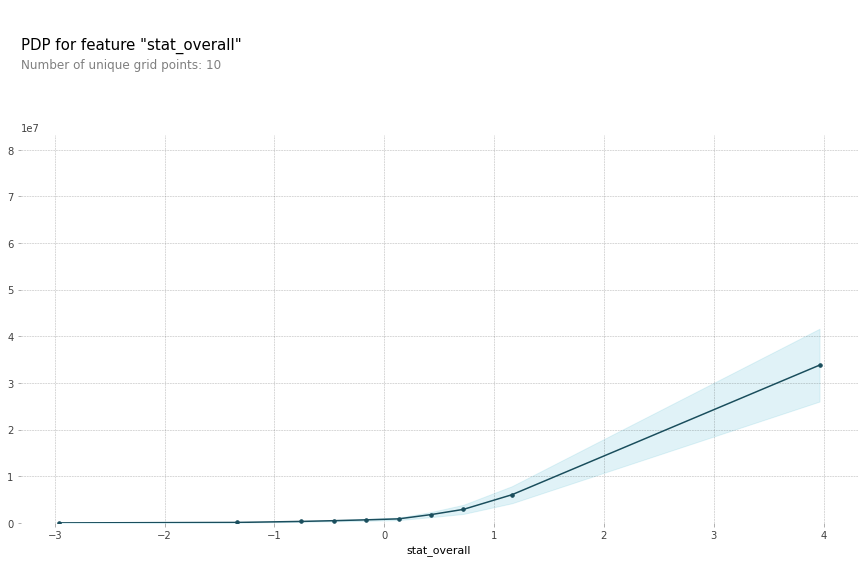

In [39]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'stat_overall'

isolated = pdp_isolate(
    model=xgb,   
    dataset= X_val_scaled, 
    model_features=X_val_scaled.columns,
    #plot_lines=True, # ICE plots
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [40]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'reputation'

isolated = pdp_isolate(
    model=xgb,   
    dataset= X_val_scaled, 
    model_features=X_val_scaled.columns,
    #plot_lines=True, # ICE plots
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

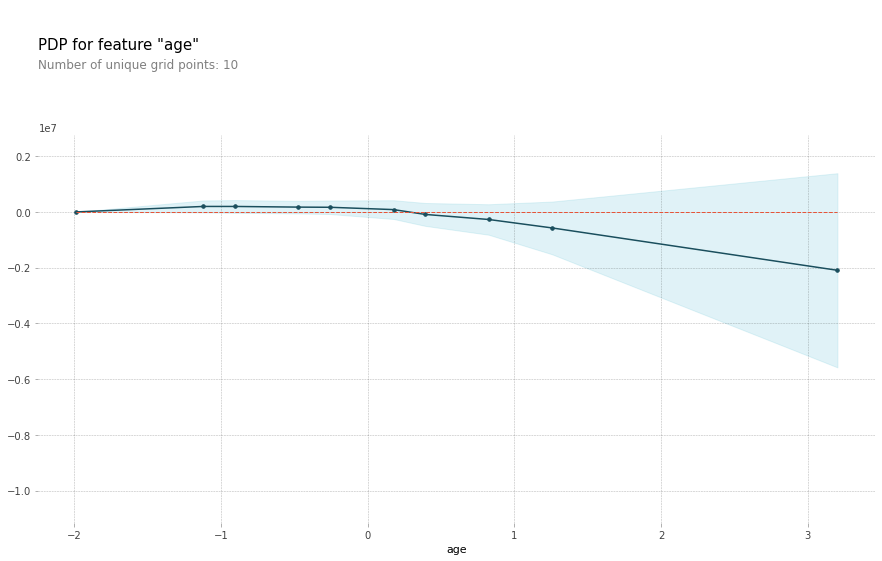

In [41]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'age'

isolated = pdp_isolate(
    model=xgb,   
    dataset= X_val_scaled, 
    model_features=X_val_scaled.columns,
    #plot_lines=True, # ICE plots
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [51]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn import preprocessing

d = preprocessing.normalize(X_val_scaled)
scaled_df = pd.DataFrame(d, columns=X_val_scaled.columns)

feature = ['stat_overall', 'stat_potential']

interaction = pdp_interact(
    model=xgb, 
    dataset=scaled_df,
    model_features=scaled_df.columns, 
    features=feature
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=feature, );

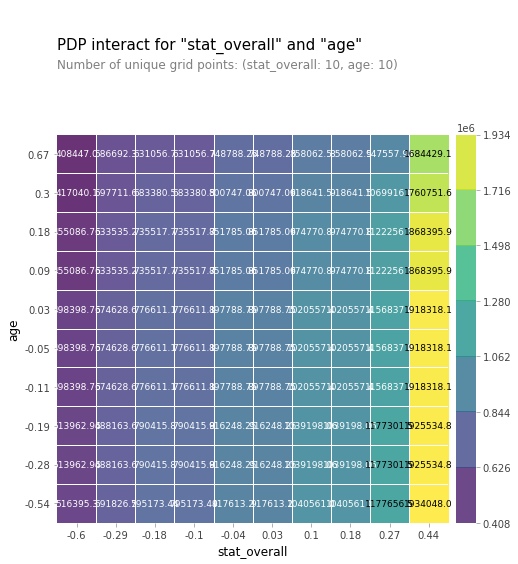

In [65]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn import preprocessing

feature = ['stat_overall', 'age']

interaction = pdp_interact(
    model=xgb, 
    dataset=scaled_df,
    model_features=scaled_df.columns, 
    features=feature
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=feature, );

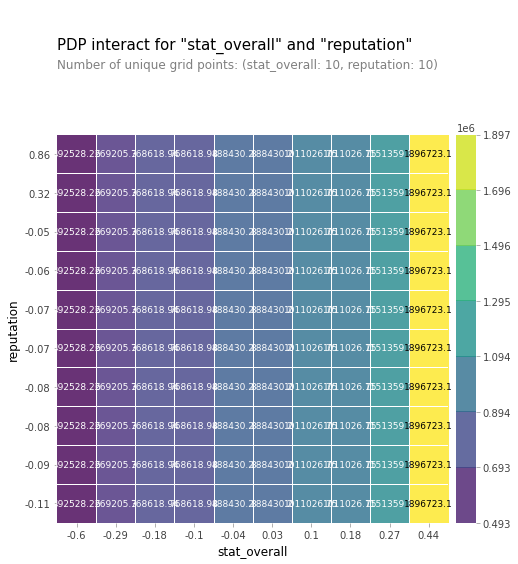

In [66]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from sklearn import preprocessing

feature = ['stat_overall', 'reputation']

interaction = pdp_interact(
    model=xgb, 
    dataset=scaled_df,
    model_features=scaled_df.columns, 
    features=feature
)

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=feature, );

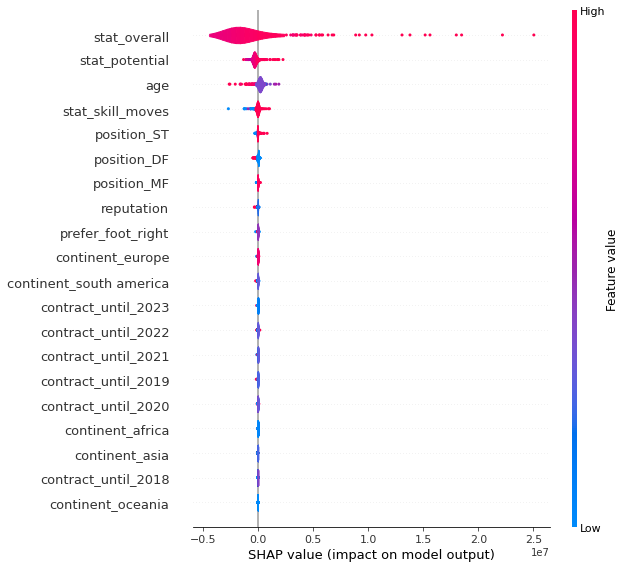

In [75]:
#SHAP

import shap

explainer = shap.TreeExplainer(xgb)
shap.initjs()
shap_values = explainer.shap_values(X_val_scaled.iloc[:300])
shap.summary_plot(shap_values, X_val_scaled.iloc[:300], plot_type='violin')

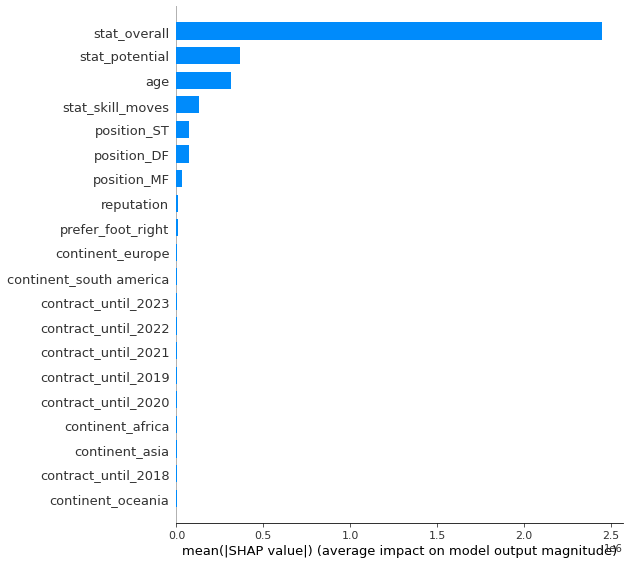

In [45]:
shap.summary_plot(shap_values, X_val_scaled.iloc[:300],plot_type='bar')

In [64]:
X_test_encoded = encoder.transform(X_test)
X_test_scaled = scaler.transform(X_test_encoded)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_encoded.columns)

In [47]:
y_test_pred = xgb.predict(X_test_scaled)
submission = sample_submission.copy()
submission['value'] = y_test_pred
submission.to_csv('submission.csv', index=False)
submission # Private score

id         value
0         1  5.417143e+07
1         2  7.993774e+07
2         4  7.196762e+07
3         5  7.182262e+07
4         6  6.264404e+07
...     ...           ...
3823  16924  5.650948e+04
3824  16929  4.555541e+04
3825  16932  5.896540e+04
3826  16937  5.520636e+04
3827  16943  4.750369e+04

[3828 rows x 2 columns]